<a href="https://colab.research.google.com/github/gladysadyaz/Hybrid-Method/blob/main/Hybrid_VARX_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [8]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"
file_path = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

Mounted at /content/drive
'Hybrid VARX_LSTM.ipynb'   Untitled0.ipynb  'wisman bali-kurs (1).xlsx'
'nyoba var-lstm.ipynb'	   VAR_YT.ipynb     'wisman bali-kurs.xlsx'
             Kurs  Wisman Bali  Hari Raya
Date                                     
2023-01-01  15592        10626          0
2023-01-02  15572        12338          0
2023-01-03  15590        12122          1
2023-01-04  15615        11957          1
2023-01-05  15610        13463          1


## **Eksplorasi Data**

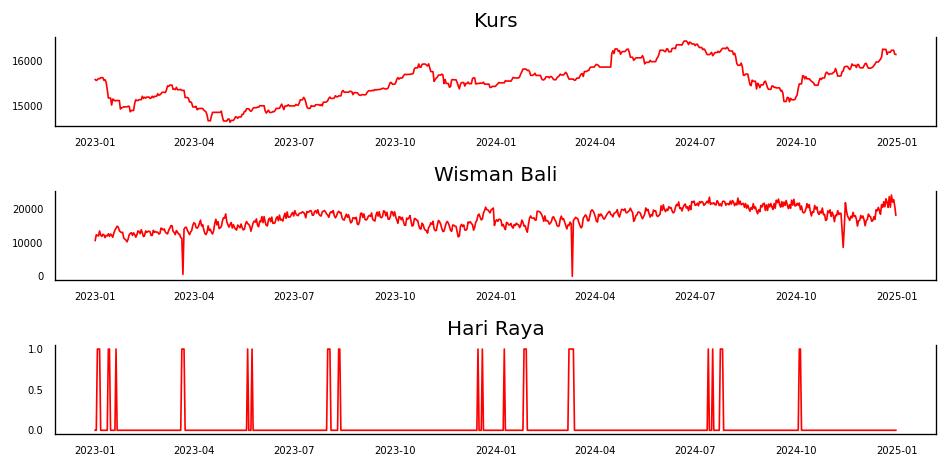

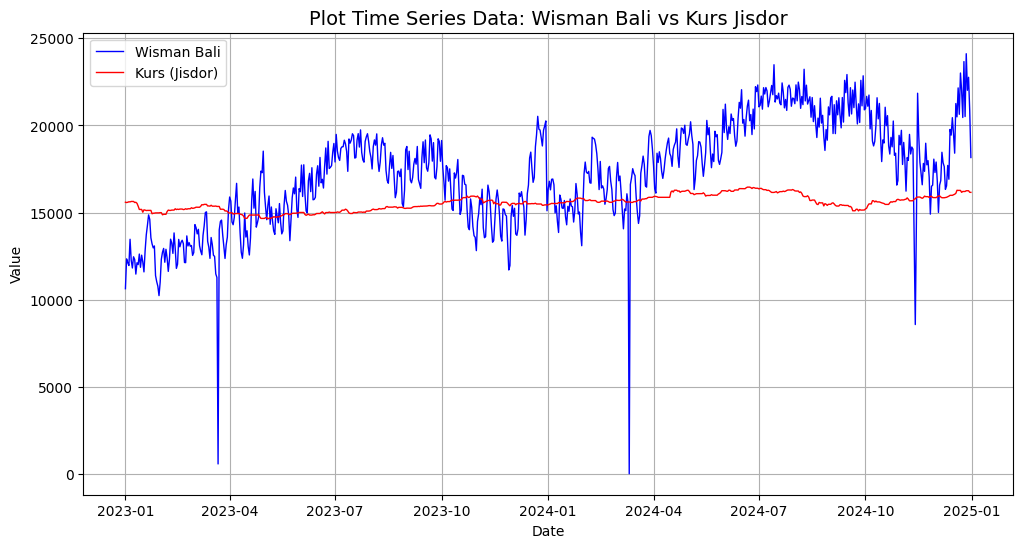

In [9]:
#Plot Data
fig, axes = plt.subplots(nrows=3, dpi=120, figsize=(8, 4))

for i, ax in enumerate(axes):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)

    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Wisman Bali'], color='blue', linewidth=1, label='Wisman Bali')
plt.plot(df['Kurs'], color='red', linewidth=1, label='Kurs (Jisdor)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot Time Series Data: Wisman Bali vs Kurs Jisdor', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


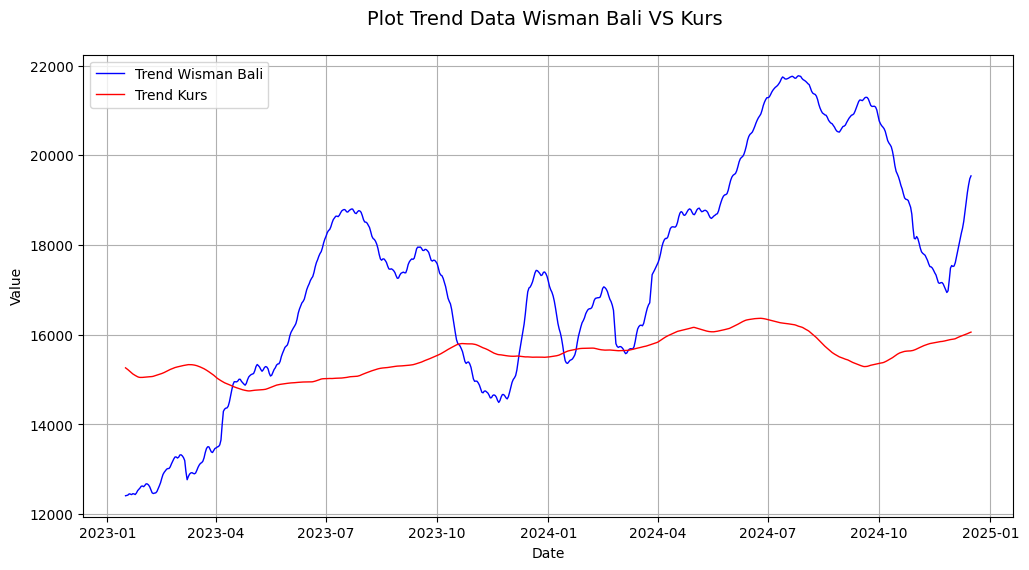

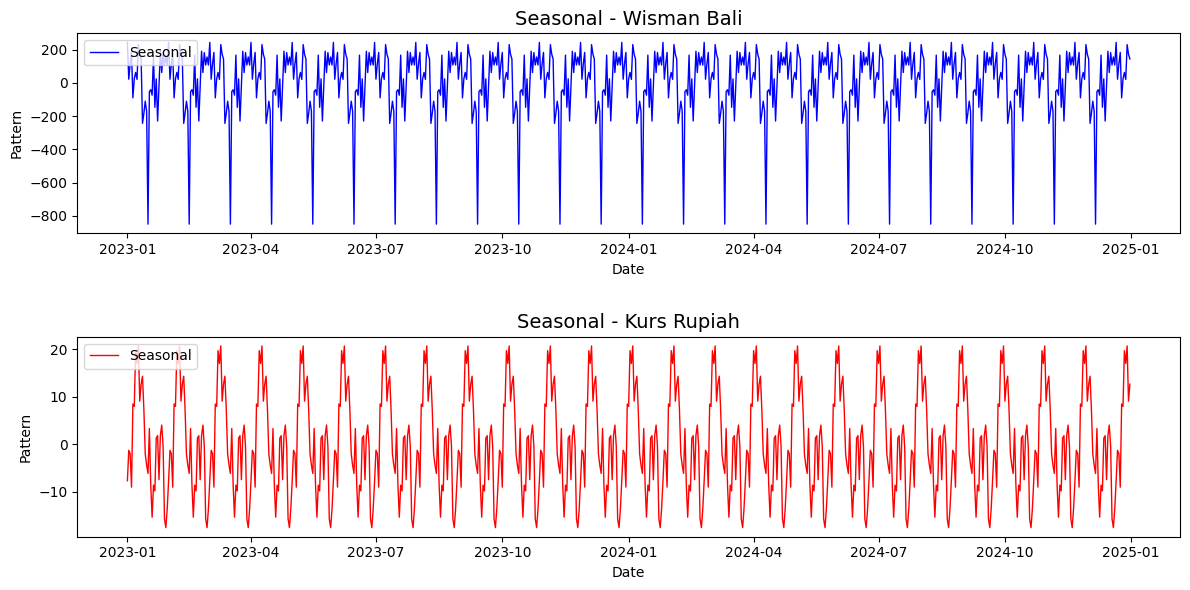

In [10]:
# Trend and Seasonal Plot
from statsmodels.tsa.seasonal import seasonal_decompose
stl_wisman = seasonal_decompose(df['Wisman Bali'], model='additive', period=30)
stl_kurs = seasonal_decompose(df['Kurs'], model='additive', period=30)
#Plotting only Trend components
plt.figure(figsize=(12, 6))
plt.plot(stl_wisman.trend, label='Trend Wisman Bali', color='blue', linewidth=1)
plt.plot(stl_kurs.trend, label='Trend Kurs', color='red', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plot Trend Data Wisman Bali VS Kurs \n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
# Plotting only Seasonal components
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stl_wisman.seasonal, label='Seasonal', color='blue', linewidth=1)
plt.title('Seasonal - Wisman Bali', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Pattern')
plt.legend(loc='upper left')
plt.subplot(2, 1, 2)
plt.plot(stl_kurs.seasonal, label='Seasonal', color='red', linewidth=1)
plt.title('\nSeasonal - Kurs Rupiah', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Pattern')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

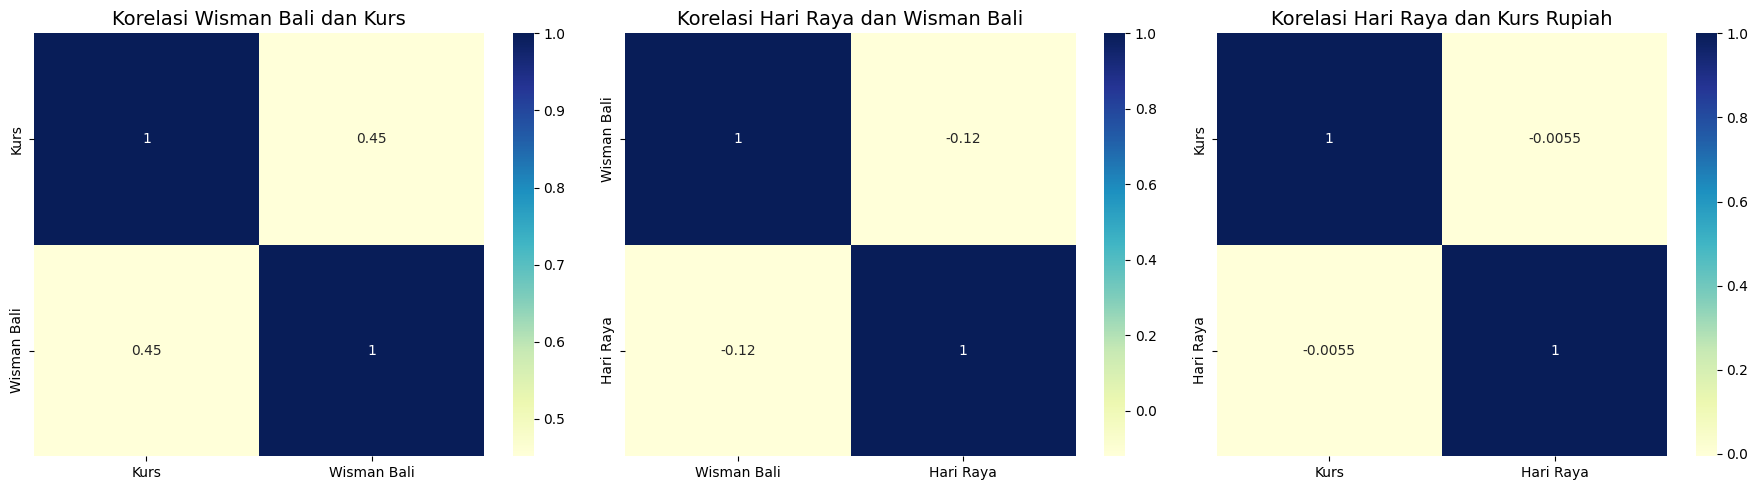

In [11]:
# Uji Korelasi
correlation_matrix1 = df[['Kurs', 'Wisman Bali']].corr()
correlation_matrix2 = df[['Wisman Bali', 'Hari Raya']].corr()
correlation_matrix3 = df[['Kurs', 'Hari Raya']].corr()
import seaborn as sns
#heatmap
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 baris, 3 kolom
correlation_matrices = [correlation_matrix1, correlation_matrix2, correlation_matrix3]
titles = ['Korelasi Wisman Bali dan Kurs', 'Korelasi Hari Raya dan Wisman Bali', 'Korelasi Hari Raya dan Kurs Rupiah']
for ax, corr_matrix, title in zip(axes, correlation_matrices, titles):
    sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", ax=ax)
    ax.set_title(title, fontsize=14)
plt.tight_layout()
plt.show()



Hubungan Kurs & Wisman Bali cukup kuat (0.45), sehingga Kurs bisa menjadi variabel penting dalam model VARX.
Hari Raya tampaknya tidak terlalu berpengaruh signifikan terhadap Kurs atau Wisman Bali berdasarkan korelasi langsung.

In [12]:
# Uji T-test
from scipy.stats import ttest_ind
# Pisahkan data saat Hari Raya dan bukan Hari Raya
kurs_hari_raya = df[df['Hari Raya'] == 1]['Kurs']
kurs_non_hari_raya = df[df['Hari Raya'] == 0]['Kurs']

t_stat, p_value = ttest_ind(kurs_hari_raya, kurs_non_hari_raya)
print(f"T-test Kurs: p-value = {p_value}")
wisman_hari_raya = df[df['Hari Raya'] == 1]['Wisman Bali']
wisman_non_hari_raya = df[df['Hari Raya'] == 0]['Wisman Bali']

t_stat, p_value = ttest_ind(wisman_hari_raya, wisman_non_hari_raya)
print(f"T-test Wisman: p-value = {p_value}")


T-test Kurs: p-value = 0.8820096498613704
T-test Wisman: p-value = 0.0010574942441761584


Jika p-value < 0.05, berarti ada perbedaan signifikan pada Kurs atau Wisman saat Hari Raya. Wisman memiliki perbedaan signifikan

In [13]:
def granger_test(df, dep_var, indep_var, maxlag=7):
    print(f"\n Uji Granger Causality: Apakah {indep_var} memengaruhi {dep_var}?")
    result = grangercausalitytests(df[[dep_var, indep_var]], maxlag=maxlag, verbose=False)

    for lag in range(1, maxlag + 1):
        p_value = result[lag][0]['ssr_ftest'][1]  # Ambil p-value dari SSR F-test

        if p_value < 0.05:
            print(f"v Lag {lag}: p-value = {p_value:.4f} (< 0.05), {indep_var} **menyebabkan** {dep_var}.")
        else:
            print(f"x Lag {lag}: p-value = {p_value:.4f} (>= 0.05), tidak ada bukti signifikan bahwa {indep_var} menyebabkan {dep_var}.")

granger_test(df, 'Wisman Bali', 'Kurs', maxlag=7)
granger_test(df, 'Kurs', 'Wisman Bali', maxlag=7)
granger_test(df, 'Kurs', 'Hari Raya', maxlag=7)
granger_test(df, 'Wisman Bali', 'Hari Raya', maxlag=7)


 Uji Granger Causality: Apakah Kurs memengaruhi Wisman Bali?
v Lag 1: p-value = 0.0001 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 2: p-value = 0.0072 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 3: p-value = 0.0407 (< 0.05), Kurs **menyebabkan** Wisman Bali.
v Lag 4: p-value = 0.0465 (< 0.05), Kurs **menyebabkan** Wisman Bali.
x Lag 5: p-value = 0.2255 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 6: p-value = 0.2879 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.
x Lag 7: p-value = 0.4949 (>= 0.05), tidak ada bukti signifikan bahwa Kurs menyebabkan Wisman Bali.

 Uji Granger Causality: Apakah Wisman Bali memengaruhi Kurs?
x Lag 1: p-value = 0.4462 (>= 0.05), tidak ada bukti signifikan bahwa Wisman Bali menyebabkan Kurs.
x Lag 2: p-value = 0.0917 (>= 0.05), tidak ada bukti signifikan bahwa Wisman Bali menyebabkan Kurs.
x Lag 3: p-value = 0.1910 (>= 0.05), tidak ada bukti signifikan bahwa Wisman Bali menyebabkan Ku

Jika p-value < 0.05, berarti Hari Raya memiliki efek signifikan terhadap Kurs atau Wisman dalam lag tertentu.

In [16]:
from statsmodels.tsa.stattools import coint
# Uji kointegrasi antara Kurs dan Wisman Bali
coint_result = coint(df['Kurs'], df['Wisman Bali'])
print("Engle-Granger Cointegration Test")
print(f"Test Statistic: {coint_result[0]}")
print(f"p-value: {coint_result[1]}")
if coint_result[1] < 0.05:
    print("Seri ini berkointegrasi (p < 0.05).")
else:
    print("Seri ini tidak berkointegrasi.")

Engle-Granger Cointegration Test
Test Statistic: -2.07199103955867
p-value: 0.4910130387494862
Seri ini tidak berkointegrasi.


In [17]:
from statsmodels.tsa.stattools import adfuller

# Fungsi ADF test
def adf_test(series, signif=0.05):
    stat, p_value, _, _, critical_values, _ = adfuller(series, autolag='AIC')
    return p_value <= signif, {'Test Statistic': stat, 'p-value': p_value, 'Critical Values': critical_values}

# Uji stasioneritas pada Wisman Bali dan Kurs
stationary_wisman, adf_wisman = adf_test(df['Wisman Bali'])
stationary_kurs, adf_kurs = adf_test(df['Kurs'])

# Tampilkan hasil
print("Augmented Dickey-Fuller Test")
for name, result, stationary in zip(["Wisman Bali", "Kurs"], [adf_wisman, adf_kurs], [stationary_wisman, stationary_kurs]):
    print(f"\n{name}")
    print(f"   Test Statistic: {result['Test Statistic']:.4f}")
    print(f"   p-value: {result['p-value']:.4f}")
    print(f"   Critical Values: {result['Critical Values']}")
    print(f"   {'Stasioner' if stationary else 'Tidak Stasioner'}")


Augmented Dickey-Fuller Test

Wisman Bali
   Test Statistic: -1.6838
   p-value: 0.4395
   Critical Values: {'1%': -3.439593802573824, '5%': -2.865619356068967, '10%': -2.568942332870462}
   Tidak Stasioner

Kurs
   Test Statistic: -1.5254
   p-value: 0.5209
   Critical Values: {'1%': -3.4394522667904153, '5%': -2.8655569894909805, '10%': -2.568909106765338}
   Tidak Stasioner


In [18]:
# Differencing agar data stasioner
df_diff = df.diff().dropna()

# Uji stasioneritas setelah differencing
stationary_wisman_diff, adf_wisman_diff = adf_test(df_diff['Wisman Bali'])
stationary_kurs_diff, adf_kurs_diff = adf_test(df_diff['Kurs'])

# Tampilkan hasil
print("ADF Test Setelah Differencing")
for name, result, stationary in zip(["Wisman Bali", "Kurs"], [adf_wisman_diff, adf_kurs_diff], [stationary_wisman_diff, stationary_kurs_diff]):
    print(f"\n{name} (Setelah Differencing)")
    print(f"   Test Statistic: {result['Test Statistic']:.4f}")
    print(f"   p-value: {result['p-value']:.4f}")
    print(f"   Critical Values: {result['Critical Values']}")
    print(f"   {'Stasioner' if stationary else 'Tidak Stasioner'}")


ADF Test Setelah Differencing

Wisman Bali (Setelah Differencing)
   Test Statistic: -7.9175
   p-value: 0.0000
   Critical Values: {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}
   Stasioner

Kurs (Setelah Differencing)
   Test Statistic: -8.0315
   p-value: 0.0000
   Critical Values: {'1%': -3.4394522667904153, '5%': -2.8655569894909805, '10%': -2.568909106765338}
   Stasioner


## **Modeling**

### **VARX**

In [94]:
df_diff.shape

(730, 3)

In [99]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VARMAX

# Differencing untuk memastikan data stasioner
df_diff = df.diff().dropna()

# Tentukan variabel endogen dan eksogen
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Cari lag optimal berdasarkan AIC
best_aic = float('inf')
best_lag = None

for lag in range(1, 21):  # Coba lag dari 1 sampai 20
    model = VARMAX(df_diff[endog_vars], exog=df_diff[exog_vars], order=(lag, 0))
    results = model.fit(disp=False)
    aic = results.aic
    print(f"Lag = {lag}, AIC = {aic}")

    # Simpan lag dengan AIC terkecil
    if aic < best_aic:
        best_aic = aic
        best_lag = lag

print(f"\nOptimal Lag untuk VARX: {best_lag}, AIC: {best_aic}")

Lag = 1, AIC = 20478.07214359023
Lag = 2, AIC = 20470.5433493724
Lag = 3, AIC = 20431.860533401807
Lag = 4, AIC = 20380.43116027346
Lag = 5, AIC = 20355.88931969628
Lag = 6, AIC = 20277.731887565584
Lag = 7, AIC = 20271.966929839826
Lag = 8, AIC = 20274.84352978151
Lag = 9, AIC = 20260.670444489348
Lag = 10, AIC = 20267.14832042932
Lag = 11, AIC = 20262.280064285933
Lag = 12, AIC = 20265.96108193286
Lag = 13, AIC = 20252.64066780599
Lag = 14, AIC = 20247.579831689916
Lag = 15, AIC = 20252.99659937535
Lag = 16, AIC = 20258.635139990358
Lag = 17, AIC = 20263.074368147783
Lag = 18, AIC = 20266.648967300913
Lag = 19, AIC = 20268.582655839997
Lag = 20, AIC = 20256.30691099343

Optimal Lag untuk VARX: 14, AIC: 20247.579831689916


In [21]:
from statsmodels.tsa.api import VARMAX
import pandas as pd
import numpy as np

# Variabel endogen dan eksogen
endog_vars = ['Kurs', 'Wisman Bali']
exog_vars = ['Hari Raya']

# Menyimpan hasil kriteria evaluasi
lag_selection = []

# Looping untuk mencari lag optimal
for lag in range(1, 21):  # Coba lag dari 1 sampai 20
    try:
        model = VARMAX(df_diff[endog_vars], exog=df_diff[exog_vars], order=(lag, 0))
        results = model.fit(disp=False)

        # Simpan hasil evaluasi jika berhasil
        lag_selection.append({
            'Lag': lag,
            'AIC': results.aic,
            'BIC': results.bic,
            'HQIC': results.hqic,
            'FPE': np.exp(results.aic / len(df_diff))  # Approximation of FPE
        })
    except Exception as e:
        print(f"Error pada lag {lag}: {e}")  # Debugging
        continue

# Konversi ke DataFrame
lag_selection_df = pd.DataFrame(lag_selection)

# Cek apakah DataFrame tidak kosong dan memiliki kolom yang benar
if not lag_selection_df.empty and all(col in lag_selection_df.columns for col in ['AIC', 'BIC', 'HQIC', 'FPE']):
    # Ubah tipe data menjadi numerik untuk mencegah error
    for col in ['AIC', 'BIC', 'HQIC', 'FPE']:
        lag_selection_df[col] = pd.to_numeric(lag_selection_df[col], errors='coerce')

    # Menentukan nilai minimum untuk setiap kriteria
    min_aic = lag_selection_df['AIC'].min()
    min_bic = lag_selection_df['BIC'].min()
    min_hqic = lag_selection_df['HQIC'].min()
    min_fpe = lag_selection_df['FPE'].min()

    # Menambahkan tanda bintang pada nilai minimum
    def highlight_min(val, min_val):
        return f"{val:.3f} *" if val == min_val else f"{val:.3f}"

    lag_selection_df['AIC'] = lag_selection_df['AIC'].apply(lambda x: highlight_min(x, min_aic))
    lag_selection_df['BIC'] = lag_selection_df['BIC'].apply(lambda x: highlight_min(x, min_bic))
    lag_selection_df['HQIC'] = lag_selection_df['HQIC'].apply(lambda x: highlight_min(x, min_hqic))
    lag_selection_df['FPE'] = lag_selection_df['FPE'].apply(lambda x: highlight_min(x, min_fpe))

    # Tampilkan hasil dalam bentuk tabel
    print(lag_selection_df)
else:
    print("Gagal melakukan estimasi untuk semua lag atau kolom tidak ditemukan.")


    Lag          AIC          BIC         HQIC                  FPE
0     1    20478.072    20528.596    20497.564    1523686161720.036
1     2    20470.543    20539.439    20497.124    1508052508125.104
2     3    20431.861    20519.128    20465.529    1430220931409.332
3     4    20380.431    20486.071    20421.188    1332927610154.216
4     5    20355.889    20479.902    20403.734    1288860860101.101
5     6    20277.732  20420.116 *  20332.665 *    1157999327658.507
6     7    20271.967    20432.723    20333.988    1148890387542.742
7     8    20274.844    20453.972    20343.953    1153426576772.456
8     9    20260.670    20458.171    20336.868    1131248577660.354
9    10    20267.148    20483.021    20350.434    1141331726063.789
10   11    20262.280    20496.525    20352.654    1133745685967.743
11   12    20265.961    20518.579    20363.423    1139477025135.277
12   13    20252.641    20523.630    20357.190    1118873375863.082
13   14  20247.580 *    20536.942    20359.218  

In [25]:
# Fit model dengan lag optimal (6 14)
model6 = VARMAX(df_diff[endog_vars], exog=df_diff[exog_vars], order=(6, 0))
model6_fit = model6.fit(disp=False)

model14 = VARMAX(df_diff[endog_vars], exog=df_diff[exog_vars], order=(14, 0))
model14_fit = model14.fit(disp=False)

print(model6_fit.summary())
print(model14_fit.summary())


                              Statespace Model Results                             
Dep. Variable:     ['Kurs', 'Wisman Bali']   No. Observations:                  730
Model:                             VARX(6)   Log Likelihood              -10107.866
                               + intercept   AIC                          20277.732
Date:                     Thu, 06 Mar 2025   BIC                          20420.116
Time:                             15:48:10   HQIC                         20332.665
Sample:                         01-02-2023                                         
                              - 12-31-2024                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.42   Jarque-Bera (JB):     791.34, 49824.12
Prob(Q):                        0.93, 0.52   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.17, 0.88   Skew:                     -0.20

Uji Ljung-Box ( Autokorelasi jika P-value < 0.05).
Kurs (0.01, p = 0.94) → tidak ada autokorelasi
Wisman (0.05, p = 0.82) → tidak ada autokorelasi.

Uji Jarque-Bera (JB) ( Normal jika P-value > 0.05)
Kurs (JB = 743.65, p = 0.00)
Wisman (JB = 54880.04, p = 0.00)

Heteroskedastisitas (Heteroskedastisitas jika P-value < 0.05)
Kurs (H = 1.16, p = 0.24) → Tidak ada heteroskedastisitas.
Wisman (H = 0.90, p = 0.41) → Tidak ada heteroskedastisitas.

- Model sudah cukup baik dalam menangani autokorelasi dan Heteroskdastisitas
- Kedua variabel tidak berdistribusi normal